# Abgabe 2 Mark Nagengast Porro, Tim Schwabe

### Aufgabe 1

In [2085]:
import networkx as nx
import numpy as np
import matplotlib as plt
import operator

In [2086]:
alpha = 2
sf = 3

In [2087]:
#Create a random graph
#edges can be duplicated
def createGraph(n_nodes, n_edges):
    G = nx.Graph()
    G.add_nodes_from([i for i in range(0,n_nodes)])

    for n in range(n_edges):
        a = np.random.randint(n_nodes)
        while True:
            b = np.random.randint(n_nodes)
            if a != b:
                break
        G.add_edge(a,b)
    
    return G

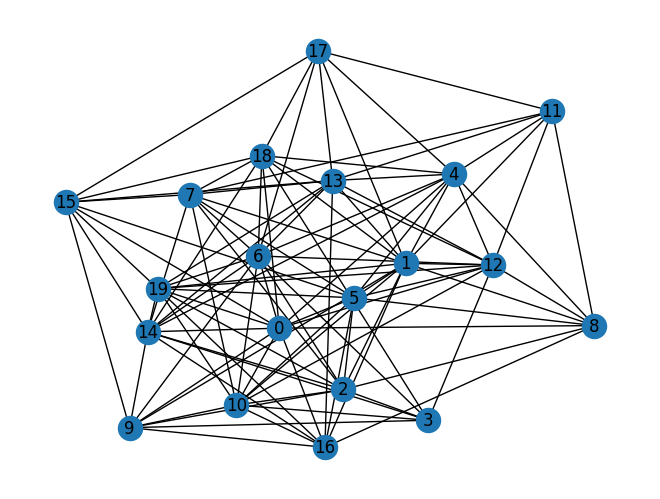

In [2088]:
#Create Graph an draw it
G = createGraph(20,150)
nx.draw(G, with_labels = True)

### Aufgabe 2

In [2089]:
#Init population 
#population of n tuple with only one node and fitness of 0
#Example: ((0,),0),((1,),0),((2,),0), ...
def init_population(G):
    nodes = list(G.nodes())
    np.random.shuffle(nodes)
    dic = dict()
    for i in nodes:
        dic.update([((len(G.nodes())-i,),0)])
    
    return dic

In [2090]:
#Fitness with penalty
#calculate the sum of edges, minus the sum of edges who are missing
def fitness(population, G):
    fitness = 0
    for key in population:
        fitness = 0
        for i in range(len(key)-1):
            for j in range(i+1,len(key)):
                if G.has_edge(key[i], key[j]):
                    fitness += 1
                else: 
                    fitness -= alpha*len(key)
                    
        population.update([(key, fitness)])


### Aufgabe 3

In [2091]:
#Selektion
#Selects the population. 
#Creates a new population with the best n and one that consists only of the solutions with the best fitness. 
#Returns the larger of the two
#n depends on the size of the graph multiplied by a fixed factor (sf)
def selection(population,G):  
    sortedPop = sorted(population.items(),key=operator.itemgetter(1),reverse=True)
    topN = dict(sortedPop[:(len(G.nodes()))*sf]) 
    best = list()
    best_value = sortedPop[0][1]
    for element in sortedPop:
        if element[1] == best_value:
            best.append(element)
        else:
            break
    np.random.shuffle(best) #shuffle to avoid a fixed order (maybe not necessary)
    if len(best) > len(topN):
        return dict(best)
    return topN


In [2092]:
#Rekombination
#Recombines the population and returns the children
#two solutions are merged and random nodes are deleted until the original solution is one node larger. 
#This always refers to the larger solution.
def recombination(pop):
    new_pop = dict()
    for i in range(len(pop)-1):
        for j in range(i+1,len(pop)):
            appended = list(set(list(pop)[i] + list(pop)[j]))
            while len(appended) > max(len(list(pop)[i]), len(list(pop)[j])) + 1:
                random_idx = np.random.choice(len(appended))
                del appended[random_idx]
            appended = tuple(appended)
            new_pop.update([(appended,0)]) #fitness always 0. it will be calculated later 
    return new_pop

In [2093]:
#Mutation
#Mutates the population and outputs it again
#Each node is mutated with the normal distribution
#Sigma depends on the size of the graph
#Additional nodes are added from the graph with a probability of 5%
def mutation(pop,G):
    newPop = dict()
    for key in pop:
        newKey = list(key)
       
        for node in newKey:
            node = np.round(node + np.random.normal(0,np.log2(len(G.nodes())),1))
            if node < 0:
                node = 0
            if node > len(G.nodes()):
                node = len(G.nodes())-1

        for node in G.nodes():
            if np.random.rand(1) < 0.05:
                newKey.append(node)
                
        newPop.update([(tuple(set(newKey)),0)]) #convert to set to delete duplicates
    
    return newPop

In [2094]:
#Algorithm
#init -> fitness -> selection -> breakup? -> recombination -> mutation 
#            ^-------------------------------------------------------
#
#This algortihmus works almost 100%.
population = init_population(G)

#keep track for the breakup condition
#If it does not return the correct result, it returns a solution with one node less than the maximum solution.
#For statistics see below
repeat_c = 0
population_sum = -100

while True:

    fitness(population,G)
    population = selection(population,G)
    
    tmp_sum = sum(population.values()) 
    if(tmp_sum == population_sum):
        repeat_c += 1
    else:
        population_sum = tmp_sum
        repeat_c = 0
    if repeat_c > np.log2(len(G.nodes())):   #breakup condition
        break

    childs = recombination(population)
    childs = mutation(childs,G)
    population = childs | population

    

print(population)
print(len(list(population)[0]) == max(len(c) for c in nx.find_cliques(G)))
print(max(len(c) for c in nx.find_cliques(G)))

{(0, 4, 6, 12, 18): 10, (1, 5, 10, 16, 19): 10, (1, 4, 8, 11, 12): 10, (2, 3, 6, 9, 10): 10, (1, 5, 10, 12, 19): 10, (1, 2, 5, 10, 19): 10, (1, 2, 5, 7, 10): 10, (1, 4, 11, 13, 17): 10, (0, 4, 5, 8, 12): 10, (2, 3, 6, 9, 14): 10, (1, 4, 5, 8, 12): 10, (0, 5, 10, 16, 19): 10, (1, 4, 11, 12, 13): 10, (0, 4, 6, 14, 18): 10, (8, 11, 12, 4): 6, (18, 12, 4, 6): 6, (8, 12, 4, 5): 6, (8, 5, 12, 4): 6, (8, 4, 12, 5): 6, (19, 10, 2, 6): 6, (8, 5, 4, 12): 6, (19, 2, 10, 6): 6, (8, 1, 12, 4): 6, (1, 18, 12, 4): 6, (2, 10, 5, 7): 6, (2, 10, 6, 7): 6, (8, 11, 4, 12): 6, (19, 12, 13, 6): 6, (1, 2, 5, 7): 6, (8, 1, 12, 5): 6, (10, 19, 12, 6): 6, (8, 1, 11, 12): 6, (8, 1, 4, 12): 6, (1, 19, 12, 13): 6, (10, 3, 12, 6): 6, (18, 4, 12, 6): 6, (1, 10, 19, 5): 6, (1, 10, 12, 5): 6, (16, 1, 19, 5): 6, (9, 2, 10, 6): 6, (15, 13, 14, 7): 6, (19, 2, 10, 5): 6, (18, 3, 12, 6): 6, (1, 10, 19, 12): 6, (17, 18, 4, 6): 6, (16, 1, 19, 13): 6, (1, 19, 12, 5): 6, (2, 14, 6, 7): 6, (1, 10, 5, 7): 6, (14, 13, 6, 7): 6, (

### Aufgabe 4

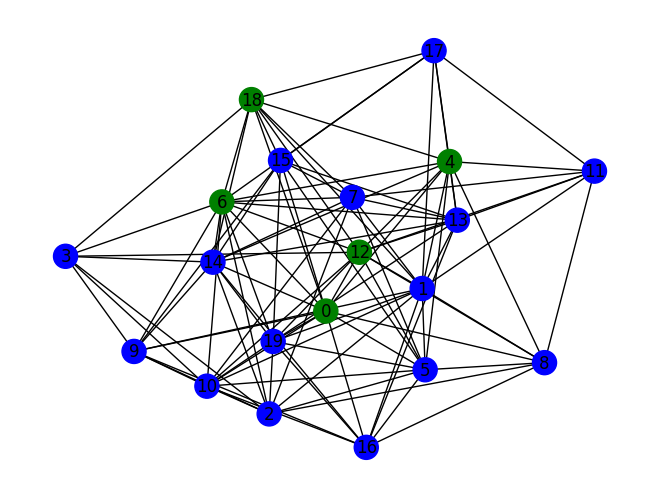

In [2095]:
color_map = []
for node in G:
    if node in list(population.keys())[0]:
        color_map.append('green')
    else: 
        color_map.append('blue')      
nx.draw(G, node_color=color_map, with_labels=True)

## The cells from here on are only for statistics

The statistics were measured during testing. They may therefore differ from the output

Config:
- Graphs: 100
- alpha: 2
- sf: 3

Stats:
- Right: 99%
- Distance between estimated size and correct size of max clique: [1]
- Runtime: 2 min 51 sec 
- Average: 1,71 sec

In [2097]:
counter = 0
wrong_list = list()
for i in range(100):
    G = createGraph(20,150)
    population = init_population(G)
    repeat_c = 0
    population_sum = -100
    while True:
        fitness(population,G)
        population = selection(population,G)
        tmp_sum = sum(population.values())
        if(tmp_sum == population_sum):
            repeat_c += 1
        else:
            population_sum = tmp_sum
            repeat_c = 0

        if repeat_c > np.log2(len(G.nodes())):
            break

        childs = mutation(recombination(population),G)
        population = population | childs

    if not len(list(population)[0]) == max(len(c) for c in nx.find_cliques(G)):
        tmp = max(len(c) for c in nx.find_cliques(G)) - len(list(population)[0])
        counter += 1
        wrong_list.append(tmp)
        print(population)        

print((100-counter)/100)
print(wrong_list)

{(2, 5, 13, 16, 19): 10, (1, 5, 10, 13, 16): 10, (1, 5, 13, 16, 17): 10, (1, 6, 10, 13, 16): 10, (1, 6, 8, 10, 16): 10, (6, 7, 8, 10, 16): 10, (1, 6, 10, 12, 13): 10, (1, 5, 10, 12, 13): 10, (6, 7, 8, 14, 16): 10, (1, 6, 13, 16, 17): 10, (4, 12, 6, 7): 6, (13, 2, 19, 5): 6, (16, 2, 13, 5): 6, (1, 10, 13, 5): 6, (5, 2, 19, 13): 6, (16, 5, 19, 13): 6, (1, 13, 5, 17): 6, (16, 1, 5, 13): 6, (16, 1, 10, 5): 6, (16, 10, 13, 6): 6, (16, 1, 10, 13): 6, (16, 10, 13, 5): 6, (17, 11, 9, 15): 6, (10, 12, 13, 6): 6, (1, 13, 12, 5): 6, (16, 17, 1, 6): 6, (8, 1, 18, 10): 6, (16, 2, 19, 5): 6, (16, 13, 19, 5): 6, (16, 2, 19, 13): 6, (16, 1, 13, 5): 6, (16, 1, 13, 17): 6, (1, 10, 13, 6): 6, (10, 12, 5, 7): 6, (16, 1, 6, 17): 6, (11, 9, 3, 17): 6, (9, 3, 14, 7): 6, (11, 9, 3, 7): 6, (9, 11, 17, 15): 6, (16, 7, 14, 6): 6, (16, 8, 6, 7): 6, (16, 1, 13, 6): 6, (1, 12, 13, 6): 6, (16, 1, 10, 6): 6, (12, 7, 6, 14): 6, (3, 12, 14, 7): 6, (12, 14, 6, 7): 6, (16, 10, 6, 7): 6, (16, 8, 10, 7): 6, (19, 2, 13, 5):

Dont run this cells below. It will take a long time

Config:
- Graphs: 100
- alpha: 2
- sf: 3

Stats:
- Right: 96%
- Distance between estimated size and correct size of max clique: [1, 1, 1, 1]
- Runtime: 26 min 32 sec 
- Average: 15,92 sec


In [ ]:
counter = 0
wrong_list = list()
for i in range(100):
    n_nodes = np.random.randint(10,50)
    n_edges = np.random.randint(n_nodes,500)
    G = createGraph(n_nodes,n_edges)
    population = init_population(G)
    repeat_c = 0
    population_sum = -100
    while True:
        fitness(population,G)
        population = selection(population,G)
        tmp_sum = sum(population.values())
        if(tmp_sum == population_sum):
            repeat_c += 1
        else:
            population_sum = tmp_sum
            repeat_c = 0

        if repeat_c > np.log2(len(G.nodes())):
            break

        childs = mutation(recombination(population),G)
        population = population | childs

    if not len(list(population)[0]) == max(len(c) for c in nx.find_cliques(G)):
        tmp = max(len(c) for c in nx.find_cliques(G)) - len(list(population)[0])
        counter += 1
        wrong_list.append(tmp)
        print(population)        

print((100-counter)/100)
print(wrong_list)

Dont run this cells below. It will take a long time!!!!

Config:
- Graphs: 1000
- alpha: 2
- sf: 3

Stats:
- Right: 98,9%
- Distance between estimated size and correct size of max clique: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
- Runtime: 29 min 8 sec 
- Average: 1,75 sec


In [ ]:
counter = 0
wrong_list = list()
for i in range(1000):
    G = createGraph(20,150)
    population = init_population(G)
    repeat_c = 0
    population_sum = -100
    while True:
        fitness(population,G)
        population = selection(population,G)
        tmp_sum = sum(population.values())
        if(tmp_sum == population_sum):
            repeat_c += 1
        else:
            population_sum = tmp_sum
            repeat_c = 0

        if repeat_c > np.log2(len(G.nodes())):
            break

        childs = mutation(recombination(population),G)
        population = population | childs

    if not len(list(population)[0]) == max(len(c) for c in nx.find_cliques(G)):
        tmp = max(len(c) for c in nx.find_cliques(G)) - len(list(population)[0])
        counter += 1
        wrong_list.append(tmp)
        print(population)        

print((1000-counter)/1000)
print(wrong_list)